# Predicting dog breeds
First, some setup

In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
### Download the dataset

(raw_train, raw_valid, raw_test), metadata = tfds.load(
    'stanford_dogs',
    split=['train', 'test[:20%]', 'test[20%:]'],
    with_info=True,
    as_supervised=True,
)

In [24]:
## Preprocess the data a little bit

IMG_SIZE = 160

def format_example(img, label):
  img = tf.cast(img, tf.float32)
  img = (img/127.5) - 1
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img, label

train = raw_train.map(format_example)
valid = raw_valid.map(format_example)
test  = raw_test.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = valid.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [38]:
# Use MobileNetV2 as pretrained model
IMG_SHAPE = IMG_SIZE, IMG_SIZE, 3
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False


# The model we are going to use
model = tf.keras.models.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),

  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dense(400, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dense(120, activation='softmax')                
])

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 200)               409800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 200)               800       
_________________________________________________________________
dense_23 (Dense)             (None, 400)               80400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 400)             

In [ ]:
# Use Xception as pretrained model
IMG_SHAPE = IMG_SIZE, IMG_SIZE, 3
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False


# The model we are going to use
channel_1, channel_2, channel_3, num_classes = 1024, 1024, 512, 120

layers = [
  base_model,
  tf.keras.layers.SeparableConv2D(channel_1, 3, padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.SeparableConv2D(channel_2, 3, padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.SeparableConv2D(channel_3, 3, padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(num_classes, activation='softmax', 
                        kernel_initializer=initializer),
  tf.keras.layers.Dropout(0.5),
]

model = tf.keras.models.Sequential(layers)

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

model.summary()

In [39]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(valid_batches, steps = validation_steps)

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=valid_batches)

20/20 [==============================] - 3s 165ms/step - loss: 4.8564 - sparse_categorical_accuracy: 0.0063
Epoch 1/20
375/375 [==============================] - 97s 258ms/step - loss: 4.2821 - sparse_categorical_accuracy: 0.0861 - val_loss: 2.4149 - val_sparse_categorical_accuracy: 0.4930
Epoch 2/20
375/375 [==============================] - 97s 260ms/step - loss: 2.9739 - sparse_categorical_accuracy: 0.2567 - val_loss: 1.6923 - val_sparse_categorical_accuracy: 0.5763
Epoch 3/20
375/375 [==============================] - 97s 260ms/step - loss: 2.4959 - sparse_categorical_accuracy: 0.3327 - val_loss: 1.5439 - val_sparse_categorical_accuracy: 0.6014
Epoch 4/20
375/375 [==============================] - 98s 260ms/step - loss: 2.2771 - sparse_categorical_accuracy: 0.3744 - val_loss: 1.4481 - val_sparse_categorical_accuracy: 0.6072
Epoch 5/20
375/375 [==============================] - 98s 261ms/step - loss: 2.1643 - sparse_categorical_accuracy: 0.4005 - val_loss: 1.4187 - val_sparse_catego

KeyboardInterrupt: ignored

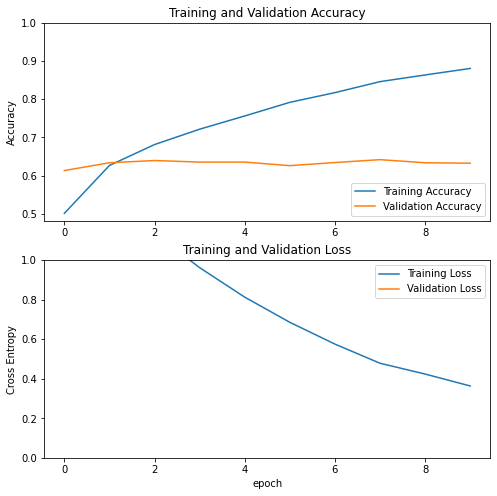

In [28]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

10612192

In [29]:
model.evaluate(test_batches)
model.save('saved_model.h5')

215/215 [==============================] - 39s 180ms/step - loss: 1.8868 - sparse_categorical_accuracy: 0.6429
